# 2.4 Fundamentals of Visualization Libraries (Part 2)

## This script contains the following:
#### [1. Import Libraries](#import-libraries)
#### [2. Import Data](#import-data)
#### [3. Set Theme](#theme)
#### [4. Data Wrangling](#wrangling)
#### [5. Bar Chart - Top 20 Stations](#top-stations)
#### [6. Dual Axis Line Chart - Daily Bike Trips + Average Temperatures](#dual-axis)
#### [7. Box Plot - Trip Duration by Season](#boxplot)
#### [8. Facet Grid - Trip Duration by Bike Type and Season](#facet)

### 1. Import Libraries<a id='import-libraries'></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scipy
from datetime import datetime as dt
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 2. Import Data<a class="anchor" id="import-data"></a>

In [2]:
folderpath = r'/Users/matthewjones/Documents/CareerFoundry/Data Visualization with Python/Achievement 2/NY-CitiBike/2. Data/Processed Data'

df = pd.read_csv(os.path.join(folderpath, 'cleaned_nyc_bike_weather_data.csv'), low_memory=False, encoding="utf-8", index_col = 0)

In [3]:
df.shape

(29838166, 19)

In [4]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'date', 'avgTemp', 'trip_duration', 'month', 'season',
       'trip_duration_outliers'],
      dtype='object')

In [5]:
df.dtypes

ride_id                    object
rideable_type              object
started_at                 object
ended_at                   object
start_station_name         object
start_station_id           object
end_station_name           object
end_station_id             object
start_lat                 float64
start_lng                 float64
end_lat                   float64
end_lng                   float64
member_casual              object
date                       object
avgTemp                   float64
trip_duration               int64
month                       int64
season                     object
trip_duration_outliers       bool
dtype: object

In [6]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,date,avgTemp,trip_duration,month,season,trip_duration_outliers
0,9D0DC440CB40CF8E,Electric Bike,2022-08-27 13:56:47.728,2022-08-27 14:02:56.651,Flatbush Ave & Ocean Ave,3704.04,3 St & Prospect Park West,3865.05,40.663657,-73.963014,40.668132,-73.973638,Casual,2022-08-27,27.8,368,8,Summer,False
1,2214991DFBE5C4D7,Electric Bike,2022-08-20 10:37:02.756,2022-08-20 10:45:56.631,Forsyth St\t& Grand St,5382.07,E 11 St & 1 Ave,5746.14,40.717798,-73.993161,40.729538,-73.984267,Casual,2022-08-20,27.9,533,8,Summer,False
2,20C5D469563B6337,Classic Bike,2022-08-31 18:55:03.051,2022-08-31 19:03:37.344,Perry St & Bleecker St,5922.07,Grand St & Greene St,5500.02,40.735354,-74.004831,40.721700,-74.002381,Member,2022-08-31,25.6,514,8,Summer,False
3,3E8791885BC189D1,Classic Bike,2022-08-02 08:05:00.250,2022-08-02 08:16:52.063,FDR Drive & E 35 St,6230.04,Grand Army Plaza & Central Park S,6839.10,40.744219,-73.971212,40.764397,-73.973715,Member,2022-08-02,26.4,711,8,Summer,False
4,8DBCBF98885106CB,Electric Bike,2022-08-25 15:44:48.386,2022-08-25 15:55:39.691,E 40 St & 5 Ave,6474.11,Ave A & E 14 St,5779.11,40.752052,-73.982115,40.730311,-73.980472,Member,2022-08-25,28.1,651,8,Summer,False


In [7]:
# Set the date to datetime
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['date'] = pd.to_datetime(df['date'])

### 3. Set Theme<a class="anchor" id="theme"></a>

In [8]:
sns.set_theme(style = 'dark', 
              palette = ['#235789', '#B9D6F2', '#F1D302', '#550C18'])

In [9]:
# Fix the order of the season column
df['season'] = pd.Categorical(df['season'], 
                              categories=['Winter', 'Spring', 'Summer', 'Fall'], 
                              ordered=True)

### 4. Data Wrangling<a class="anchor" id="wrangling"></a>

#### TOP START STATIONS

In [10]:
# Subset the data to reduce memory load
df_station_start = pd.DataFrame(df['start_station_name'])

In [11]:
# Create a new column to count the number of rows
df_station_start['value'] = 1

In [12]:
# Count the number of rows for each start station, and find the top 20 by that count
df_station_start = df_station_start.groupby('start_station_name')['value'].count().reset_index()
top_start_stations = df_station_start.nlargest(20, 'value')

#### AVERAGE MONTHLY TEMPERATURE

In [13]:
# Subset the data to reduce memory load
df_temp = df[['date', 'avgTemp']]

In [14]:
# Reduce data to only include one datapoint per day
df_temp_grouped = df_temp.groupby(['date']).mean().reset_index()

In [15]:
# Set the date column to be the index
df_temp_grouped = df_temp_grouped.set_index('date')

In [16]:
# Calculate the daily number of bike rides using groupby
df_group = pd.DataFrame(df.groupby(['date'])['ride_id'].count()).reset_index()
df_group.rename(columns = {'ride_id':'bike_rides_daily'}, inplace = True)

In [17]:
# Outer merge df_temp_grouped with df_group
df_merged = df_temp_grouped.merge(df_group, on = "date", how = 'outer', indicator = True)
print(df_merged['_merge'].value_counts(dropna = False))
print("Shape of December 30th is", df[df['date'] == '2022-12-30'].shape) # Check 
print("Shape of December 31st is", df[df['date'] == '2022-12-31'].shape) # Second check 

df_merged = df_merged.set_index('date')

_merge
both          365
left_only       0
right_only      0
Name: count, dtype: int64
Shape of December 30th is (62298, 19)
Shape of December 31st is (31466, 19)


In [18]:
# Ensure the index is a datetime variable
df_merged.index = pd.to_datetime(df_merged.index)

#### DEALING WITH OUTLIERS
    Previous distribution charts have shown a very a long tail towards long trips. For any visualization on the distribution of 'trip_duration', we need to eliminate outliers.

In [19]:
# Reduce starting dataframe to eliminate the top 5% of outliers
no_outliers = df.loc[df['trip_duration_outliers'] == False]

### 5. Bar Chart - Top 20 Stations<a class="anchor" id="top-stations"></a>

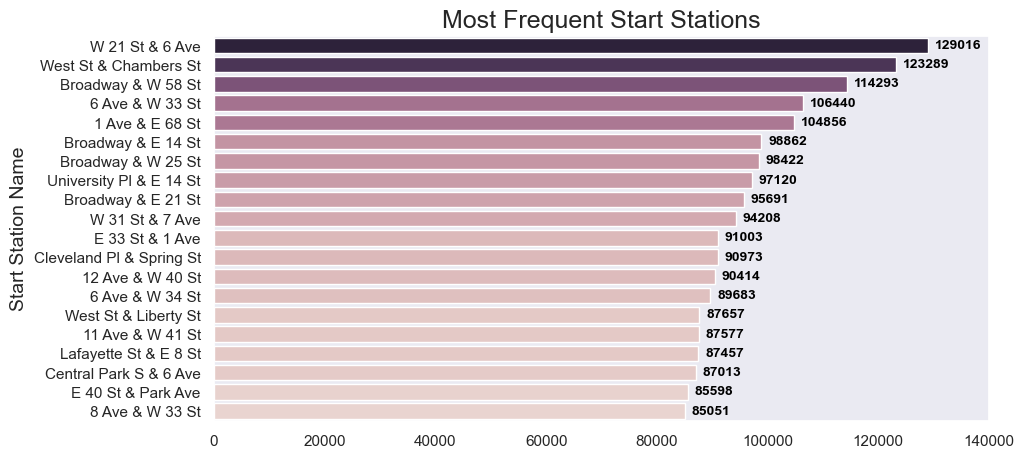

In [20]:
# Create figure and axis objects with subplots() and details
fig, ax = plt.subplots(figsize = (10, 5))

# Use a new color palette, instead of the user-defined palette
with sns.color_palette('PuRd_r', n_colors = 20):
    sns.barplot(data = top_start_stations, # Create the bar plot
                x = 'value', 
                y = 'start_station_name', 
                hue = 'value',
                legend = False)
    
    # Add labels to bar chart
    for i in ax.containers:
        ax.bar_label(i, fontsize = 10, fontweight=550, padding = 5, color = 'black')

    ax.set_xlim([0, 140000]) # Expand axis to fit lables

    # Set axis labels and titles
    ax.set_xlabel('') 
    ax.set_ylabel('Start Station Name',
             fontsize = 14) 
    plt.title('Most Frequent Start Stations', fontsize = 18)

plt.show()

### 6. Dual Axis Line Chart - Daily Bike Trips + Average Temperatures<a class="anchor" id="dual-axis"></a>

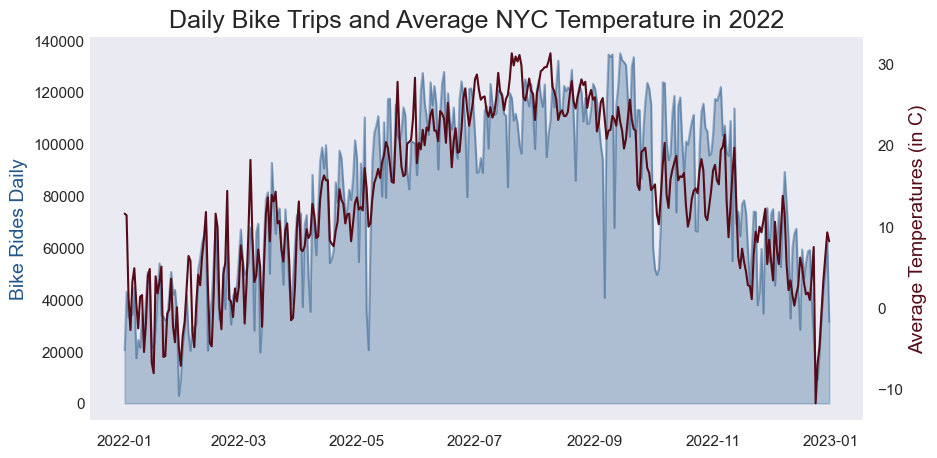

In [21]:
# Create figure and axis objects with subplots() and details
fig, ax = plt.subplots(figsize=(10, 5))
palette = ['#235789', '#B9D6F2', '#F1D302', '#550C18'] # Re-define palette colors

# Make a plot of the bike rides (left y-axis)
sns.lineplot(data = df_merged['bike_rides_daily'],
             color= palette[0],
             alpha = 0.4)
ax.fill_between(df_merged.index, # Fill in the area underneath the plot
                df_merged['bike_rides_daily'], 
                color= palette[0], 
                alpha = 0.3)
ax.set_xlabel('') # Set x-axis label
ax.set_ylabel('Bike Rides Daily', # Set y-axis label
              color = palette[0], 
              fontsize = 14) 
ax.tick_params(axis='y', which='both', length=0) # Eliminate axis tick marks
ax.yaxis.set_ticks_position('none')

# Initialize a twin object for two different y-axes on the sample plot
ax2 = ax.twinx()

# Make a plot of the average temperatures (right y-axis)
sns.lineplot(data = df_merged['avgTemp'],
             color = palette[3], 
             ax = ax2)
ax2.set_ylabel('Average Temperatures (in C)', # Set y-axis label
               color = palette[3],
               fontsize = 14)
ax2.yaxis.set_ticks_position('none') # Eliminate axis tick marks

# Set titles
plt.title('Daily Bike Trips and Average NYC Temperature in 2022', 
          fontsize = 18)

plt.show()

### 7. Box Plot - Trip Duration by Season<a class="anchor" id="boxplot"></a>

In [22]:
# Subset the data to reduce memory load
df_season = no_outliers[['ride_id', 'season', 'trip_duration']]

In [23]:
# Calculations for styling the median value labels
medians = df_season.groupby(['season'])['trip_duration'].median()
vertical_offset = df_season['trip_duration'].median() * 0.05 # offset from median for display

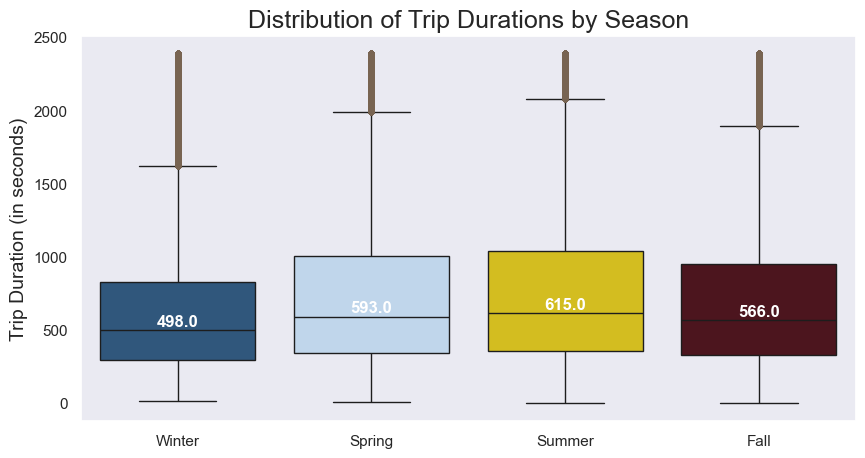

In [24]:
# Create figure and axis objects with subplots() and details
fig, ax = plt.subplots(figsize = (10,5))

# Make a box plot
box = sns.boxplot(x = 'season', 
                  y = 'trip_duration', 
                  data = df_season, 
                  hue = 'season', 
                  flierprops = {'marker': 'o', # Control the formatting of the outlier markers
                                'markersize' : 3,
                                'markeredgecolor' : '#786452'},
                  legend = False)

# Include median data labels for each season
for x in box.get_xticks():
    box.text(x, 
             medians[x] + vertical_offset, # y-axis position
             medians[x], # x-axis position
             horizontalalignment = 'center',
             fontsize = 12,
             color = 'w',
             weight = 'semibold')

# Set axis labels and titles
ax.set_xlabel('') 
ax.set_ylabel('Trip Duration (in seconds)',
             fontsize = 14) 
plt.title('Distribution of Trip Durations by Season', 
          fontsize = 18)

plt.show()

#### INSIGHTS:
    Previously, we saw that total daily trips was correlated to weather. In this visualization, trip duration is also slightly correlated to season. Without more sophisticated statistical tests, it's hard to tell if these differences are significant, but trips are shortest in the winter and longest in the summer. This chart looks at seasonal trends (which is our primary objective), but we could also use a scatter plot to measure the correlation between average daily temperature and trip duration.

    In each month, there are a number of longer rentals. For this chart, we removed the longest of these rentals, but it may also be compelling to see if there is a correlation between the outliers that were left out and season.

### 8. Facet Grid - Trip Duration by Bike Type and Season<a class="anchor" id="facet"></a>

In [25]:
# Subset the data to reduce memory load
df_facet = no_outliers[['ride_id', 'rideable_type', 'season', 'trip_duration']]

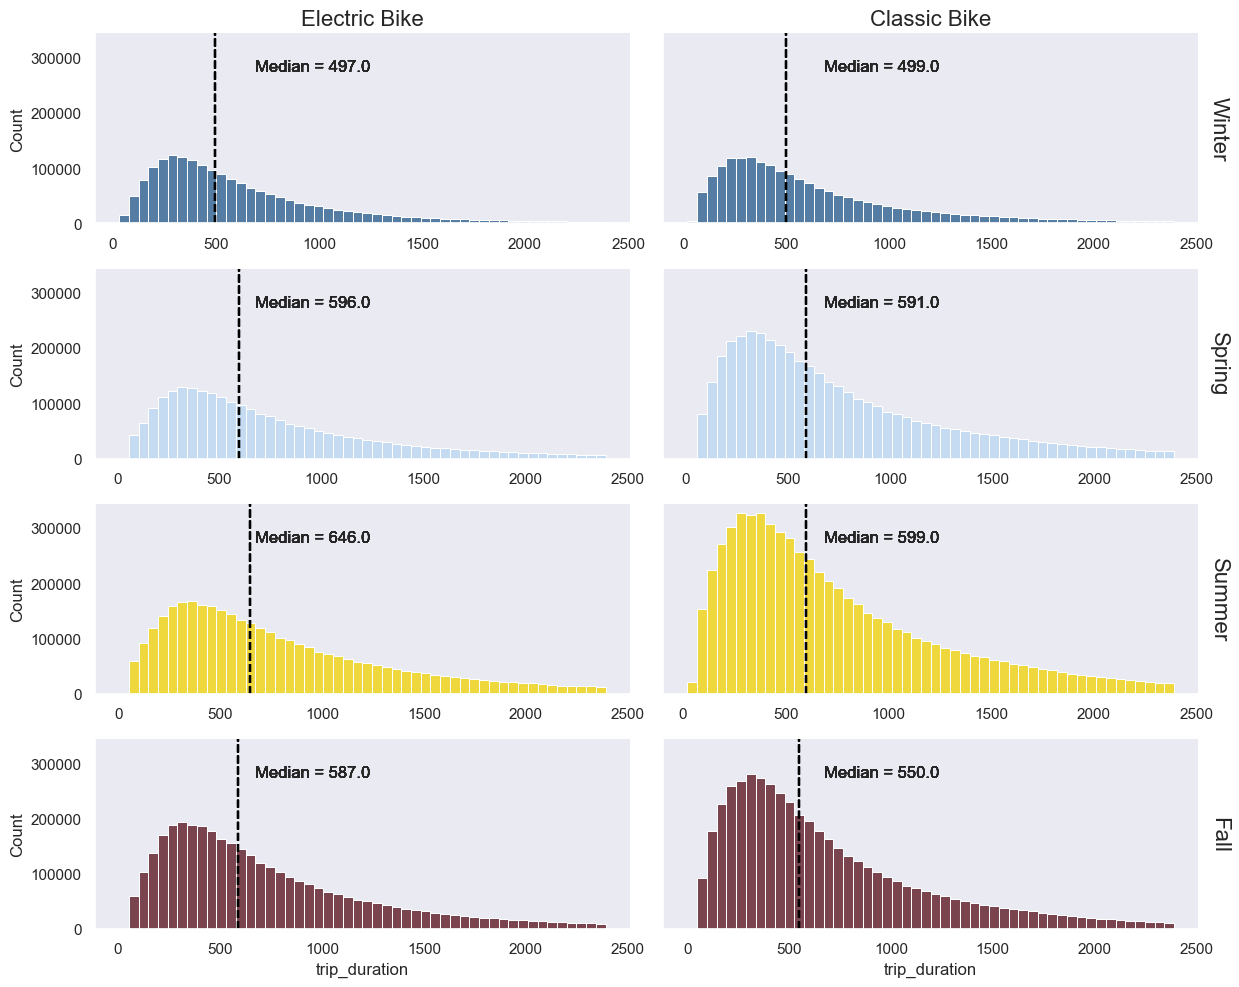

In [26]:
# Create the facet grid
grid = sns.FacetGrid(df_facet, 
                     col = 'rideable_type', # Set the bike type to be the column variable
                     row = 'season', # Set the season to be the row variable
                     hue = 'season',
                     margin_titles = True, # Place the variables on the sides of the grid
                     height = 2.5,
                     aspect = 2.5,
                     sharex = False)

# Look at the distribution of trip duration by the facets
grid.map(sns.histplot, 
         'trip_duration', 
         bins = 50)

axes = grid.axes.flatten()

def annotate(data, **kws):
    for i, ax in enumerate(axes):
        ax = plt.gca()
        n = data.trip_duration.median()
        ax.text(.3, .8, "Median = {:.1f}".format(n), transform = ax.transAxes)
        ax.axvline(x = n, color = 'black', linestyle = '--')

grid.map_dataframe(annotate)

# Set titles
grid.set_titles(col_template = '{col_name}', 
                row_template = '{row_name}',
                size = 16)

plt.show()

#### INSIGHTS:
    The distribution of trip duration is roughly the same for season and for each type of bicycle. The most common trip duration is between 250 - 300 seconds (~5 min). For each chart, the median is consistent with the median identified in the previous boxplot. Most rentals were in the summer and the fewest in the winter. And trip duration is also correlated to season.